In [1]:
import sys
sys.path.append('../../')

from photochem_box_model import PhotochemBoxModel
from chempath import Chempath
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import pandas as pd
import numpy as np
import os

# Running box model

To exemplify the application of Chempath to a simple scenario we developed a photochemical box model that solves the equation:

\begin{equation}
 \frac{dn_i}{dt} = P_i - D_i
\end{equation}

where $n_i$ is the number density of a species $i$, $P_i$ is its chemical production and $D_i$ is its chemical destruction.  To keep the model as simple as possible, we assume that photochemical reactions have constant rates. We obtain these rates by running a more complex photochemical model that solves radiative transfer and using similar rates to the ones obtained by this model at a specific altitude. For all other reactions, we use the same reaction rate parameters used by this complex model, and calculate their reaction rate constants as an Arrhenius rate.  The purpose of this simple model is to exemplify the use of the pathway analysis algorithm, not be an accurate representation of the stratospheric O3 chemistry (see section \ref{complex_example} for a more realistic example). We use a reaction system with 15 reactions between 8 species involving O3 and HOx chemistry. 

We can initialize this model with the following code:

In [2]:
box_model = PhotochemBoxModel('templates/chapman_HOx/')

In this example we will use a reaction system with 15 reactions involving HOx and O3 chemistry:

In [3]:
box_model.print_reactions()

O2 + hv --> O + O
O2 + O --> O3
O3 + hv --> O2 + O
O3 + O --> O2 + O2
O3 + hv --> O2 + O1D
O2 + hv --> O + O1D
H2O + O1D --> OH + OH
OH + O3 --> HO2 + O2
HO2 + O3 --> OH + O2 + O2
HO2 + O --> OH + O2
OH + HO2 --> H2O + O2
HO2 + HO2 --> H2O2 + O2
H2O2 + OH --> HO2 + H2O
OH + OH --> H2O2
H2O2 + O --> OH + HO2


Let's run this model for 80 days:

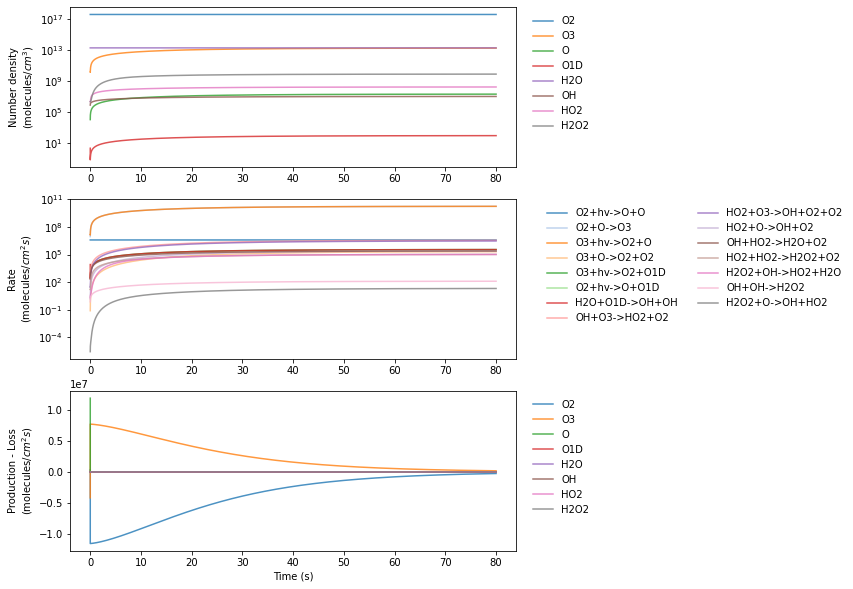

In [4]:
# Run box model
days = 60*60*24
total_time = 80 * days
box_model.solve_bdf(total_time, max_step=60*60)
solution = box_model.solution

# plot solution
fig, axs = plt.subplots(3, 1, figsize=(8,10))

# plot number densities
plt.sca(axs[0])
for i, sp in enumerate(box_model.species_list[:-1]):
    plt.plot(solution.time/days, solution.conc[i, :], label=sp, alpha=0.8)
plt.yscale('log')
plt.ylabel('Number density\n'+  r'(molecules/$cm^3$)')
plt.legend(frameon=0, ncol=1, bbox_to_anchor=(1.1, 1), loc='upper center')

# plot reaction rates
plt.sca(axs[1])
colors=sns.color_palette('tab20', len(box_model.reaction_equations))
for i, reaction in enumerate(box_model.reaction_equations):
    plt.plot(solution.time/days, solution.rates[i, :], label=reaction, 
        alpha=0.8, color=colors[i])
plt.yscale('log')
plt.ylabel('Rate\n'+  r'(molecules/$cm^2 s$)')
plt.legend(frameon=0, bbox_to_anchor=(1.4, 1), loc='upper center',
           ncol=2)

# plot production - loss
plt.sca(axs[2])
for i, sp in enumerate(box_model.species_list[:-1]):
    plt.plot(solution.time/days, solution.chempl[i, :], label=sp, alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Production - Loss\n'+'(molecules$/cm^2s$)')
plt.legend(frameon=0, ncol=1, bbox_to_anchor=(1.1, 1), loc='upper center')

All species in the model reach a steady state after 80 days, and there is an increase in the O3 number density.

To apply chempath to this model we need to transfer the output into files readable by chempath. Our box model has a method called `solution_to_chempath_input` that does this and saves the chempath input files to the `chempath_input` folder (see the code source for further details)

In [5]:
box_model.solution_to_chempath_input('chempath_input/', step=15, start=90)

# Using Chempath

The function above saves the reactions rates, the species concentrations, the model time and the reaction system to the folder `output/` at different times in the model run. For example, we can use saved info at the first time step to create a chempath object:

In [6]:
# create a chempath object
chempath = Chempath(
            reactions_path=f'chempath_input/reactions.txt',
            rates_path=f'chempath_input/rates_1.dat',
            species_path=f'chempath_input/species.txt',
            conc_path=f'chempath_input/num_densities_1.dat',
            time_path=f'chempath_input/time_1.dat',
            f_min=0,
            ignored_sb=['O2', 'O3', 'H2O'],
            dtype=float

        )

# find pathways
chempath.find_all_pathways()

# print  pathways contribution to O3 loss
O3_loss_contributions = chempath.get_pathways_contributions('O3', 
    'loss')[['pathway', 'contribution']]
print(O3_loss_contributions.to_markdown())


|    | pathway                     |   contribution |
|---:|:----------------------------|---------------:|
|  0 | O3+hv -> O2+O1D             |    0.648479    |
|    | H2O+O1D -> OH+OH            |                |
|    | OH+O3 -> HO2+O2             |                |
|    | OH+HO2 -> H2O+O2            |                |
|    | Net:2O3 -> 3O2              |                |
|  1 | O3+hv -> O2+O1D             |    0.116352    |
|    | H2O+O1D -> OH+OH            |                |
|    | Net:O3 + H2O -> O2 + 2OH    |                |
|  2 | OH+O3 -> HO2+O2             |    0.0995442   |
|    | HO2+O3 -> OH+O2+O2          |                |
|    | Net:2O3 -> 3O2              |                |
|  3 | O3+hv -> O2+O1D             |    0.0656151   |
|    | H2O+O1D -> OH+OH            |                |
|    | 2(OH+O3 -> HO2+O2)          |                |
|    | Net:3O3 + H2O -> 3O2 + 2HO2 |                |
|  4 | O3+hv -> O2+O1D             |    0.0449472   |
|    | H2O+O1D -> OH+OH     

We run chempath in each of the model time steps saved above with the following code

In [7]:
def get_contributions(sol_folder, species, f_min=0):
    '''Gets pathways contribution in all input files found in sol_folder'''
    nfiles = len([x for x in os.listdir(sol_folder) if 'time' in x])

    prod_dfs = []
    loss_dfs = []
    chempath_list = []

    # find pathways at each time step
    for i in range(1,nfiles):
        chempath = Chempath(
            reactions_path=f'{sol_folder}/reactions.txt',
            rates_path=f'{sol_folder}/rates_{i}.dat',
            species_path=f'{sol_folder}/species.txt',
            conc_path=f'{sol_folder}/num_densities_{i}.dat',
            time_path=f'{sol_folder}/time_{i}.dat',
            f_min=f_min,
            ignored_sb=['O2', 'O3', 'H2O'],
            dtype=float

        )
        chempath.find_all_pathways()

        # get contributions
        chempath_list.append(chempath)
        prod = chempath.get_pathways_contributions(species, on='production')
        loss = chempath.get_pathways_contributions(species, on='loss')
        prod['species'] = species
        loss['species'] = species
        prod['time'] = chempath.mean_time
        loss['time'] = chempath.mean_time
        prod_dfs.append(prod)
        loss_dfs.append(loss)
    
    prod_dfs = pd.concat(prod_dfs)
    loss_dfs = pd.concat(loss_dfs)

    prod_dfs['time'] = prod_dfs['time']
    loss_dfs['time'] = loss_dfs['time']
    return prod_dfs, loss_dfs, chempath_list

o3_prod_pathways, o3_loss_pathways, chempath_list =\
    get_contributions('chempath_input/', species='O3')

We can see these pathways at a specific time step

In [8]:
# get unique times
times = o3_loss_pathways.time.unique()

# get pathways at timestep number 10
pathways_time_10 = o3_loss_pathways[o3_loss_pathways.time
             == times[10]][['pathway', 'contribution']]
# print pathways
print(pathways_time_10.to_markdown())

|    | pathway                     |   contribution |
|---:|:----------------------------|---------------:|
|  0 | OH+O3 -> HO2+O2             |    0.703676    |
|    | HO2+O3 -> OH+O2+O2          |                |
|    | Net:2O3 -> 3O2              |                |
|  1 | O3+hv -> O2+O1D             |    0.152806    |
|    | H2O+O1D -> OH+OH            |                |
|    | OH+O3 -> HO2+O2             |                |
|    | OH+HO2 -> H2O+O2            |                |
|    | Net:2O3 -> 3O2              |                |
|  2 | O3+hv -> O2+O               |    0.0573993   |
|    | OH+O3 -> HO2+O2             |                |
|    | HO2+O -> OH+O2              |                |
|    | Net:2O3 -> 3O2              |                |
|  3 | O3+hv -> O2+O1D             |    0.0356421   |
|    | H2O+O1D -> OH+OH            |                |
|    | OH+O3 -> HO2+O2             |                |
|    | HO2+HO2 -> H2O2+O2          |                |
|    | H2O2+OH -> HO2+H2O   

The main O3 destruction pathway is:

In [9]:
# get main O3 loss pathway
print(pathways_time_10.iloc[0].pathway)

OH+O3 -> HO2+O2
HO2+O3 -> OH+O2+O2
Net:2O3 -> 3O2


Now lets plot the contribution of the pathways to O3 destruction over time:

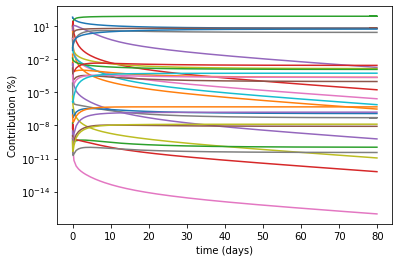

In [10]:
# get unique pathway ids
loss_pathway_ids = o3_loss_pathways.pathway_id.unique()

# plot each pathway contribution over time
plt.figure()
for pid in loss_pathway_ids:
    data_pathway = o3_loss_pathways[o3_loss_pathways.pathway_id==pid]
    plt.plot(data_pathway.time/days, data_pathway.contribution * 100)
plt.xlabel('time (days)')
plt.ylabel('Contribution (%)');
plt.yscale('log')



Here isa more detailed plot:

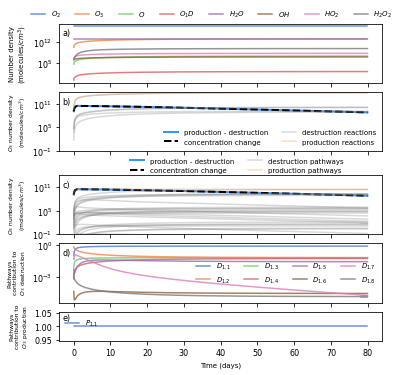

In [11]:
# size of figure to fit in a4 page size
a4_x, a4_y = (8.27, 11.69)

# set ticks size
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=8)

path = 'chempath_input'
nfiles = len([ x for x in os.listdir(path) if 'time' in x])
species = np.loadtxt(f'{path}/species.txt', dtype=str, delimiter=',')
nspecies = len(species)


# get time, number densities and concentration changes
time = [] 
num_densities = []
dconc =[] # concentration change
for i in range(1,nfiles):
    nd = np.fromfile(f'{path}/num_densities_{i}.dat', dtype=float)
    dconc_t = nd[nspecies:] - nd[:nspecies]
    nd = nd[:nspecies]
    t = np.mean(np.fromfile(f'{path}/time_{i}.dat', dtype=float))
    time.append(t)
    num_densities.append(nd)
    dconc.append(dconc_t)
time = np.array(time)
num_densities = np.array(num_densities)
dconc = np.array(dconc)


# remove deleted pathways contributions
o3_loss_pathways = o3_loss_pathways[o3_loss_pathways.pathway_id != 'del']
o3_prod_pathways = o3_prod_pathways[o3_prod_pathways.pathway_id != 'del']


days = 60*60*24
labels = [r'$O_2$', r'$O_3$', r'$O$', r'$O_1D$', r'$H_2O$', r'$OH$',
    r'$HO_2$', r'$H_2O_2$']
colors = sns.color_palette('muted', len(labels))
fig, axs = plt.subplots(6,1, figsize=(0.7*a4_x, 0.5*a4_y), sharex=True,
    gridspec_kw={'height_ratios':[1, 1, 0.1,  1, 1, 0.5]}                      
        )

# plot number densities
plt.sca(axs[0])
for i, sp in enumerate(species[:-1]):
    # if sp not in ['O2', 'H2O']:
    plt.plot(time/days, num_densities[:, i], label=labels[i],
        color=colors[i], alpha=0.8)
axs[0].text(0.01, 0.8, 'a)', transform=axs[0].transAxes, size=8)
plt.yscale('log')
plt.ylabel('Number density\n'+  r'(molecules/$cm^3$)', fontsize=7)
plt.legend(frameon=0, fontsize=7, ncol=8, bbox_to_anchor=(1.05, 1.35))

# calculate production - loss
react_prod = np.array([np.multiply(chempath.sij, chempath.rj)*chempath.dt 
        for chempath in chempath_list])
total_react_prod = np.sum(react_prod, axis=2)

plt.sca(axs[1])
# plot production - loss
plt.plot(time/days, total_react_prod[:,1], color='#3395ff', lw=2,
         label = 'production - destruction')
# plot concentration changes
plt.plot(time/days, dconc[:,1], color='k', linestyle='--', lw=2, 
    label=r'concentration change')
# plot individual reactions production
chempath1 = chempath_list[1]
for i in range(react_prod.shape[-1]):
    if chempath1.sij[1,i] > 0:
        plt.plot(time/days, react_prod[:,1,i], color='#ff9033', alpha=0.3,
                label='production reactions')
    else:
        if i ==0:
            plt.plot(time/days, np.abs(react_prod[:,1,i]), color='gray',
                alpha=0.3, label='destruction reactions')
        else:
            plt.plot(time/days, np.abs(react_prod[:,1,i]), color='gray', alpha=0.3)
plt.yscale('log')
plt.ylim([1e-1, 1e14])
axs[1].text(0.01, 0.8, 'b)', transform=axs[1].transAxes, size=8)
plt.legend(frameon=0, fontsize=7, ncol=2)
plt.ylabel('$O_3$ number density \n'+  r'(molecules/$cm^3$)', fontsize=6)

axs[2].set_axis_off()
plt.sca(axs[3])
# calculate pathway production - loss
pathway_prod = np.array([np.multiply(chempath.mik, chempath.fk)*chempath.dt
    for chempath in chempath_list])
total_pathway_prod = np.sum(pathway_prod, axis=2)
# plot pathway production - loss
plt.plot(time/days, total_pathway_prod[:,1], color='#3395ff', lw=2,
    label = 'production - destruction')
# plot concentration changes
plt.plot(time/days, dconc[:,1], color='k', linestyle='--', lw=2,
    label=r'concentration change')
chempath1 = chempath_list[-1]
for i in range(pathway_prod.shape[-1]):
    if chempath1.mik[1,i] > 0:
        plt.plot(time/days, pathway_prod[:,1,i], color='#ff9033', alpha=0.3,
            label='production pathways')
    else:
        if i == 0:
            plt.plot(time/days, np.abs(pathway_prod[:,1,i]), color='gray', alpha=0.3,
                label='destruction pathways')
        else:
            plt.plot(time/days, np.abs(pathway_prod[:,1,i]), color='gray', alpha=0.3)
plt.yscale('log')
plt.ylim([1e-1, 1e14])
plt.legend(frameon=0, fontsize=7, ncol=2, bbox_to_anchor=(0.9, 1.4))
axs[3].text(0.01, 0.8, 'c)', transform=axs[3].transAxes, size=8)
plt.ylabel('$O_3$ number density \n'+  r'(molecules/$cm^3$)', fontsize=6)

# plot destruction pathways contributions
plt.sca(axs[4])
pathway_ids = o3_loss_pathways[o3_loss_pathways.time == time[-1]].iloc[:8].pathway_id
colors = sns.color_palette('muted', len(pathway_ids))
labels = [r'$D_{1.1}$', r'$D_{1.2}$', r'$D_{1.3}$', r'$D_{1.4}$', r'$D_{1.5}$',
    r'$D_{1.6}$', r'$D_{1.7}$', r'$D_{1.8}$']
for i, pid in enumerate(pathway_ids):
    data_pathway = o3_loss_pathways[o3_loss_pathways.pathway_id == pid]
    plt.plot(data_pathway.time/days, data_pathway.contribution, label=labels[i],
        color=colors[i], alpha=0.8)
plt.ylabel('Pathways\n contribution to\n $O_3$ destruction', fontsize=6)
axs[4].text(0.01, 0.8, 'd)', transform=axs[4].transAxes, size=8)
plt.legend(frameon=0, fontsize=7, ncol=4)
plt.yscale('log')

# plot production pathways contributions
plt.sca(axs[5])
colors = sns.color_palette('muted', 2)
plt.plot(o3_prod_pathways.time/days, o3_prod_pathways.contribution, 
    label=r'$P_{1.1}$', color=colors[0], alpha=0.8)
plt.ylabel('Pathways\n contribution to\n $O_3$ production', fontsize=6)
plt.legend(frameon=0, fontsize=7)
plt.xlabel('Time (days)', fontsize=7)
axs[5].text(0.01, 0.7, 'e)', transform=axs[5].transAxes, size=8);


In this plot Panel **a** presents the evolution of the model over time. Panel **b** shows the O3 concentration change over time (black dotted line), the O3 production (orange line) and destruction (grey lines) by the reactions in the model, and the O3 production minus its destruction by reactions (blue line). This panel shows that the reactions completely explain the O3 concentration change. Panel  **c** is the same as panel b, but for O3 production and destruction by the pathways found by Cempath. This panel shows these pathways explain the O3 concentration change. Panel **d** shows the contribution of the 8 most important pathways to O3 destruction, and panel **d** shows the contribution of pathways to O3 production. .